## 주제 :  코로나 일일 확진자와 영양제/다이어트식품 검색량에 관계가 있는지 알아보자 

### 세부 가설 1 : 코로나 일일 확진자 수 증가 후에는 건강을 우려한 사람들로 인하여 영양제 검색량도 증가할 것이다 
### 
### 세부 가설 2 : 코로나 확진자 수의 증가 추세가 완화된 기간에는 다이어트 식품 검색량이 증가할 것이다  

#### 설정 

In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumGothic.ttf").get_name()
rc('font', family=font_name)

In [2]:
%matplotlib inline
%config inLineBackend.figure_format = 'retina' 

### 기초작업 

#### 기본 파일 불러오기

In [3]:

#전체 검색량 데이터 가져오기 
df_result = pd.read_csv("data/search_result.csv", encoding="utf-8-sig",index_col=0)
#코로나 확진자 데이터 가져오기 
covid = pd.read_csv("data/Covid19InfState.csv", encoding="utf-8-sig")
#성별/연령별 일간 검색량 데이터 가져오기

f_kid = pd.read_csv("data/df2_f_kid.csv", encoding="utf-8-sig", index_col=0) #여성 미성년자
f_20 = pd.read_csv("data/df2_f_20.csv", encoding="utf-8-sig", index_col=0) #여성 20대
f_30 = pd.read_csv("data/df2_f_30.csv", encoding="utf-8-sig", index_col=0) #여성 30대
f_40 = pd.read_csv("data/df2_f_40.csv", encoding="utf-8-sig", index_col=0) #여성 40대
f_senior = pd.read_csv("data/df2_f_senior.csv", encoding="utf-8-sig", index_col=0) #여성 50대이상
m_kid = pd.read_csv("data/df2_m_kid.csv", encoding="utf-8-sig", index_col=0) #남성 미성년자
m_20 = pd.read_csv("data/df2_m_20.csv", encoding="utf-8-sig", index_col=0) #남성 20대
m_30 = pd.read_csv("data/df2_m_30.csv", encoding="utf-8-sig", index_col=0) #남성 30대
m_40 = pd.read_csv("data/df2_m_40.csv", encoding="utf-8-sig", index_col=0) #남성 40대
m_senior = pd.read_csv("data/df2_m_senior.csv", encoding="utf-8-sig", index_col=0) #남성 50대이상 


#### 1. 전체 검색량 데이터 처리 (df_result)

#### 1-1. 상대값에서 절댓값으로 변환

In [4]:
df_realvalue = df_result.iloc[:,1:]
scaler = 2258.17661650362
df_realvalue = round(df_realvalue*scaler, 1)
df_realvalue.insert(0, "date", df_result["date"])

#### 1-2. 전체 검색량 데이터 구분
- 현재 검색량 데이터에는 영양제에 해당하는 카테고리와 다이어트식품에 해당하는 카테고리가 다 들어가있음
- 이를 구분하여 두 개의 데이터프레임으로 만드는 과정 
- 기존의 네이버 쇼핑 데이터에서 카테고리 값을 가져와서 해당 카테고리 값이랑 일치하는 것만 남기는 방식으로 처리 
- 이 과정에서, 네이버 데이터랩 크롤링시 제외하였던 카테고리들은 삭제함 

In [5]:
nutrients = pd.read_csv("data/nutrients_data_complete.csv", encoding = "utf_8_sig", index_col = 0)
healthfood = pd.read_csv("data/healthfood_data_complete.csv", encoding = "utf_8_sig", index_col = 0)

In [6]:
#기타 비타민, 기타 영양제, 기타 건강식품은 네이버 데이터랩 검색어에서 제외하였음
#실수로 영양제에 곤약을 넣어서..ㅎㅎ 제외함 
nut_list = list(nutrients["cate_5"].unique())
nut_list.remove("기타비타민")
nut_list.remove("기타영양제")
nut_list.remove("곤약")
#nut_list.remove("기타건강식품")
food_list = list(healthfood["cate_4"].unique())


In [7]:
df_nut = df_realvalue[nut_list]
df_nut["date"] = df_realvalue["date"]
df_nut = df_nut.set_index("date")
df_nut["nut_sum"] = df_nut.sum(axis=1)
df_food = df_realvalue[food_list]
df_food["date"] = df_realvalue["date"]
df_food = df_food.set_index("date")
df_food["food_sum"] = df_food.sum(axis=1)

df_nut = df_nut.reset_index()
df_food = df_food.reset_index()

<ipython-input-7-e8185b2e5933>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nut["date"] = df_realvalue["date"]
<ipython-input-7-e8185b2e5933>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_food["date"] = df_realvalue["date"]


#### 2. 코로나 데이터 처리 (covid)
1. 필요한 컬럼만 가져오기(날짜, 누적확진자 수 ) 
2. 검색량 데이터랑 date 형태 맞추기 
3. 누적확진자수로 일일 확진자 수 구하기 

In [9]:
#필요한 컬럼만 가져오기
#stateDt:날짜, decideCnt:누적 확진자 수 
covid = covid[["stateDt", "decideCnt"]]
covid["stateDt"] = covid.astype(str) 

#covid trend 데이터의 date 형식을 df_nut_2020, df_food_2020과 맞추기 (yyyy-mm-dd)
covid["stateDt"] = covid["stateDt"].apply(lambda x : x[0:4]+"-"+x[4:6]+"-"+x[6:])
covid = covid.rename(columns={"stateDt" : "date"})

<ipython-input-9-5dae53fcd5e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid["stateDt"] = covid.astype(str)
<ipython-input-9-5dae53fcd5e1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid["stateDt"] = covid["stateDt"].apply(lambda x : x[0:4]+"-"+x[4:6]+"-"+x[6:])


In [10]:
# 누적 확진자수 decideCnt를 일간 확진자수 daycnt로 변환
# 현재 누적 확진자 수에서 직전 확진자 수를 뺌 
#비정상적인 값 처리 (누적 확진자 수인데 해당일의 다음날보다 많은 이상한 값이 존재해서 이전일, 다음일의 평균으로 처리 )

daycnt = [0]
decidecnt= covid["decideCnt"]
decidecnt.fillna(0)
decidecnt.loc[3] = (decidecnt.loc[2] + decidecnt.loc[4])/2
decidecnt.loc[116] = (decidecnt.loc[115] + decidecnt.loc[117])/2
decidecnt.loc[347] = (decidecnt.loc[346] + decidecnt.loc[348])/2

decidecnt = list(decidecnt)

for i in range(1, len(decidecnt)) : 
    daycnt.append(decidecnt[i] - decidecnt[i-1])

covid["daycnt"] = daycnt 

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [11]:
#### 추가 처리. 2020년 1월 1일부터 보려고 slicing 

In [12]:
#2020년 1월 1일부터 보려고 slicing 함
df_nut_2020 = df_nut[df_nut["date"] >= "2020-01-01"]
df_food_2020 = df_food[df_food["date"] >= "2020-01-01"]

#그리고 total_trend로 합침 
total_trend  = pd.merge(left = df_nut_2020, right = df_food_2020, on ="date")
total_trend = pd.merge(left=total_trend, right=covid[["date", "daycnt"]], 
                       on="date", how="outer")

#### 3. 성별, 연령별 검색량 데이터 처리 (f_kid ~ m_senior)
#### 


#### 3-1. 성별, 연령별 검색량의 상댓값 -> 절댓값 변환 

- 개별 데이터프레임의 1열부터 스케일러를 곱해주는 함수 생성 (0열은 날짜이므로 곱하지 않음) 
- 절댓값 변환을 위해 곱해줄 숫자(스케일러)를 dict_scaler 변수에 딕셔너리 형태로 넣고 
- 반복문으로 데이터프레임 리스트에서 데이터프레임을, 딕셔너리에서 스케일러를 순차적으로 가져와 곱해주도록 함  

In [13]:

dict_scaler = [{"남성_미성년자":56.86732781},
               {"남성_20대":471.5872413},
               {"남성_30대":480.9030332},
               {"남성_40대":191.1705019},
               {"남성_50대이상":54.65492228},
               {"여성_미성년자":55.79250648}, 
               {"여성_20대":465.8577269},
               {"여성_30대":553.5560949}, 
               {"여성_40대":293.2608899},
               {"여성_50대이상":122.0345283}] 



In [14]:
def scaler(dataframe, scale) : 
    dataframe.iloc[:,1:] = dataframe.iloc[:,1:] * scale
    return dataframe

In [15]:

file_list = [m_kid, m_20, m_30, m_40, m_senior, f_kid, f_20, f_30, f_40, f_senior]
key_list = ["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

for index, dataframe in enumerate(file_list):
    scale = dict_scaler[index].get(key_list[index])
    scaler(dataframe, scale)


#### 3-2. 성별, 연령별 검색량을 합친 전체 데이터 프레임 생성 
- 개별 데이터프레임을 합치기 위한 데이터프레임 형태로 변형
- 하나의 데이터프레임으로 merge

In [16]:
#합치기 위한 데이터 프레임 형태로 변형하는 함수 생성 
#컬럼을 date, cate_5, 그리고 남성_미성년자 ~ 여성_50대 이상으로 만들기

file_list = [m_kid, m_20, m_30, m_40, m_senior, f_kid, f_20, f_30, f_40, f_senior]
name_list = ["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

def preprocess(dataframe) : 
    dataframe = dataframe.set_index("date")
    dataframe = pd.DataFrame(dataframe.stack().reset_index())
    
    return dataframe

In [17]:
#개별 데이터 프레임에 함수를 적용하고 

df_m_kid = preprocess(m_kid)
df_m_20 = preprocess(m_20)
df_m_30 = preprocess(m_30)
df_m_40 = preprocess(m_40)
df_m_senior = preprocess(m_senior)
df_f_kid = preprocess(f_kid)
df_f_20 = preprocess(f_20)
df_f_30 = preprocess(f_30)
df_f_40 = preprocess(f_40)
df_f_senior = preprocess(f_senior)


In [18]:
#df_total이라는 데이터 프레임으로 합치기

df_total = pd.DataFrame()
df_total = pd.merge(left=df_m_kid, right=df_m_20, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_m_30, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_m_40, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_m_senior, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_kid, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_20, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_30, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_40, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_senior, how="outer", on=["date", "level_1"] )

#컬럼명 재설정 
df_total.columns = ["date", "cate_5", "남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

In [19]:
df_total["date"] = df_total["date"].astype(str)

#### 3-3. 성별, 연령별 검색량의 전체 데이터 프레임(df_total)을 영양제와 다이어트식품으로 구분하기  
- 앞서 생성한 카테고리 리스트(nut_list, food_list) 변수 사용 

In [20]:
nut_total = df_total[df_total["cate_5"].isin(nut_list)]
food_total = df_total[df_total["cate_5"].isin(food_list)]

### 시각화

#### 0. 영양제 총 검색량 / 다이어트식품 총 검색량의 성별, 연령 분포 
- 영양제의 2018년 이후 총 검색량의 성별, 연령 분포 
- 다이어트식품의 2018년 이후 총 검색량의 성별, 연령 분포
- 영양제, 다이어트 식품의 2018년 이후 총 검색량의 성별, 연령 분포

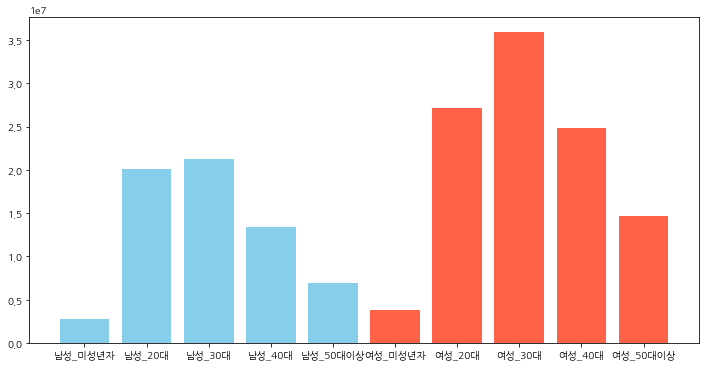

In [21]:
#영양제 
plt.figure(figsize = (12, 6))
plt.bar(list(nut_total.columns[2:7]), nut_total.iloc[:,2:7].sum(axis = 0), color = "skyblue") #남성의 영양제 총검색량        
plt.bar(list(nut_total.columns[7:]), nut_total.iloc[:,7:].sum(axis = 0), color = "tomato") #여성의 영양제 총검색량

plt.show()

<BarContainer object of 5 artists>

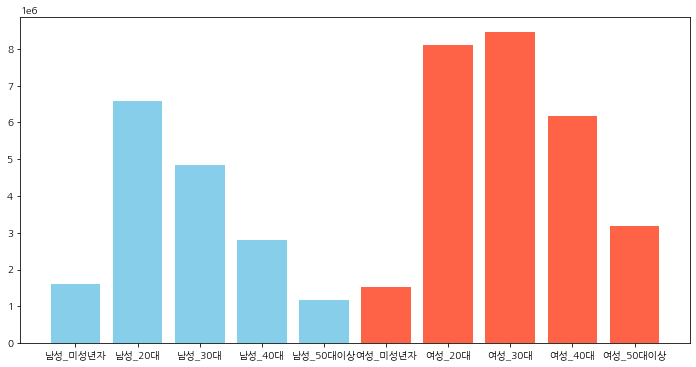

In [22]:
#다이어트식품
plt.figure(figsize = (12, 6))
plt.bar(list(food_total.columns[2:7]), food_total.iloc[:,2:7].sum(axis = 0), color = "skyblue") #남성의 다이어트식품 총검색량        
plt.bar(list(food_total.columns[7:]), food_total.iloc[:,7:].sum(axis = 0), color = "tomato") #여성의 다이어트식품 총검색량

In [23]:
#같이 보기 
search_amount_1 = pd.DataFrame(nut_total.iloc[:, 2:].sum())
search_amount_1["cate"] = "영양제"
search_amount_2 = pd.DataFrame(food_total.iloc[:, 2:].sum())
search_amount_2["cate"] = "다이어트식품"
search_amount = pd.concat([search_amount_1, search_amount_2], axis=0)
search_amount.reset_index(inplace = True)
search_amount = search_amount.rename(columns={0:"amount"})

<AxesSubplot:xlabel='index', ylabel='amount'>

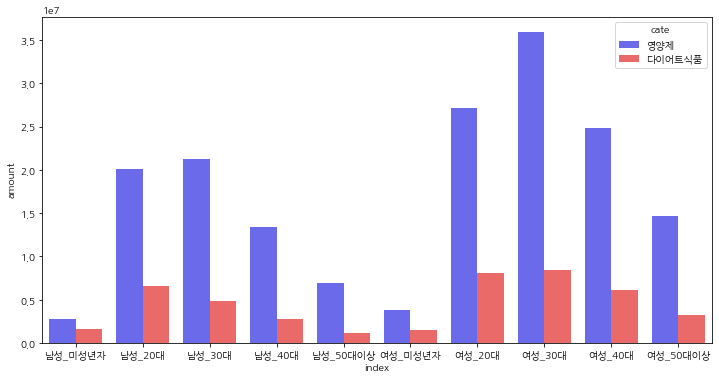

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=search_amount, x="index", y="amount", hue="cate", palette="seismic") 

#### 1. 영양제 총 검색량 / 다이어트식품 총 검색량과 코로나 일일 확진자 수의 그래프 그리기 
- 왼쪽 : 영양제 - 코로나  /  오른쪽 : 다이어트식품 - 코로나

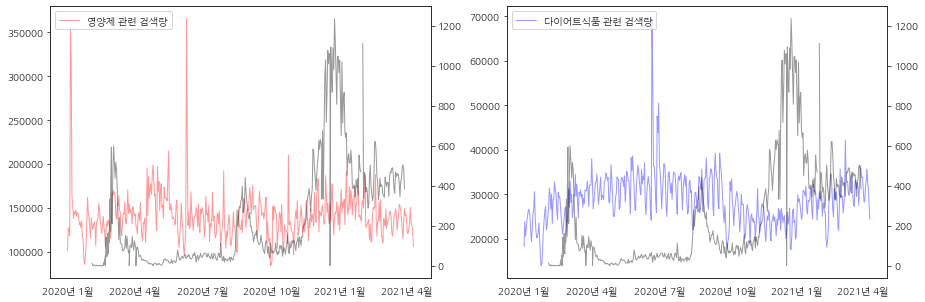

In [25]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
plot1 = ax1.plot(total_trend["date"], total_trend["nut_sum"], "-", color='red', lw=1, alpha=0.4, 
                 label = "영양제 관련 검색량")
plot2 = ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='black', lw=1, alpha=0.4)
plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월",
                    "2021년 1월","2021년 4월"])
ax1.legend(loc = "upper left")

ax3 = plt.subplot(122)
ax4 = ax3.twinx()
plot3 = ax3.plot(total_trend["date"], total_trend["food_sum"], "-", color='blue', lw=1, alpha=0.4,
                label = "다이어트식품 관련 검색량")
plot4 = ax4.plot(total_trend["date"], total_trend["daycnt"], "-", color='black', lw=1, alpha=0.4)
plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월",
                    "2021년 1월","2021년 4월"])
ax3.legend(loc = "upper left")    

plt.show()

#### 2. 세부 카테고리별 검색량 - 코로나 일일 확진자 수 그래프 그리기 
- trend_graph : 검색량을 조회하고 싶은 세부 카테고리를 리스트형으로 넣으면 그래프를 그려주는 함수 
- (여기서 조회되는 검색량은 해당 카테고리에 대한 검색량으로, 성별/연령에 대한 구분이 없음) 

In [355]:
def trend_graph(catenames) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot()
      
    for i, value in enumerate(catenames) : 
        plot1 = ax1.plot(total_trend["date"], total_trend[value], "-", lw=1, alpha=1, label = f"{value}")
        ax1.legend(loc = "upper left")
    
    ax2 = ax1.twinx()
    plot2 = ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', lw=1, alpha=0.7, label = "코로나 일일 확진자")
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    ax2.legend(loc = "upper right")
    plt.show()

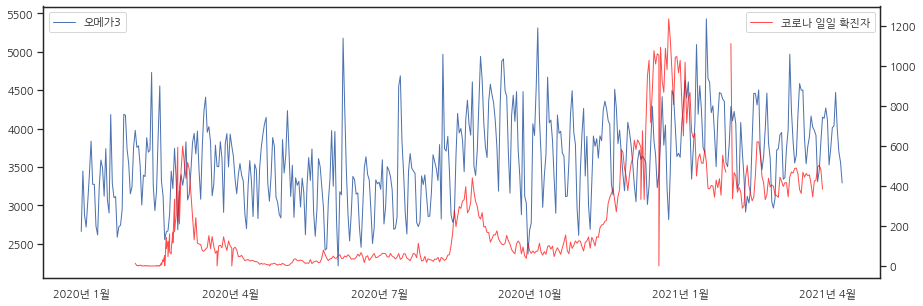

In [358]:
trend_graph(["오메가3"]) ## 여기에 리스트 형태로 카테고리를 넣어주세요 

In [28]:
total_trend.columns ## << 카테고리 목록을 확인하려면 이쪽 

Index(['date', '수면보조제', '아르기닌(아미노산)', '효소', '은행추출물', '초록입홍합', '헤모힘', '타트체리',
       '매스틱', '구연산', '마카', '초유단백질', '양태반', '아미노산', '베타카로틴', '엘더베리', '커큐민',
       '석류추출물', '퀘르세틴', '기타식물추출물', '크랜베리', '베타인 HCL', '숙취해소제', '요오드', '라이코펜',
       '나토키나제', '노니', '마늘', '타우린', '폴리페놀', '대구 간유', '녹용/녹혈', 'SAMe', '프로바이오틱스',
       '밀크씨슬', '멀티비타민', '오메가3', '크릴오일', '비타민C', '환자식/영양보충식', '루테인', '홍삼',
       '프리바이오틱스', '마그네슘', '엽산', '프로폴리스', '폴리코사놀', '비타민B', '기타건강보조식품', '칼슘',
       '알로에정/겔', '비타민D', '코큐텐', '철분', '보스웰리아', '효모', '스피루리나', '아연', '키토산',
       '쏘팔메토', '글루코사민', '비오틴', '감마리놀렌산', 'MSM', '칼륨', '건강분말', '클로렐라', '셀레늄',
       '헛개나무', '건강음료', '로얄제리', '비타민A', '스쿠알렌', '건강환/정', '석류즙', '기타건강즙', '꿀',
       '비타민E', 'nut_sum', '콜라겐', '기타다이어트식품', '뷰티푸드', '헬스보충제', '다이어트차', '곤약쌀',
       '곤약젤리', '식이섬유', '가르시니아', '기타곤약가공품', '다이어트바', '잔티젠', '레몬밤', 'CLA', '카테킨',
       '히알루론산', '와일드망고', 'food_sum', 'daycnt'],
      dtype='object')

#### 3. 코로나19 일간 확진자와 연령별/성별별 검색량 그래프 그리기 
- 영양제 / 다이어트식품을 구분하여 그리기 


In [29]:
nut_search = nut_total.groupby("date").sum().reset_index()
nut_search_2020 = nut_search[nut_search["date"] >= "2020-01-01"]
nut_search_2020["date"] = pd.to_datetime(nut_search_2020["date"])

food_search = food_total.groupby("date").sum().reset_index()
food_search_2020 = food_search[food_search["date"] >= "2020-01-01"]
food_search_2020["date"] = pd.to_datetime(food_search["date"])

<ipython-input-29-a5998958d347>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nut_search_2020["date"] = pd.to_datetime(nut_search_2020["date"])
<ipython-input-29-a5998958d347>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_search_2020["date"] = pd.to_datetime(food_search["date"])


In [30]:
total_trend["date"] = pd.to_datetime(total_trend["date"]) #날짜 변환

In [31]:
#영양제


def nut_graph(columns) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    
    ax1 = fig.add_subplot()
    for i, value in enumerate(columns) : 
        ax1.plot(nut_search_2020["date"], nut_search_2020[value], "-", lw=1, alpha=0.8, label = f"{value}")
        ax1.legend(loc = "upper left")  
    
    ax2 = ax1.twinx()
    ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', 
                     lw=1, alpha=0.5, label = "코로나 일일 확진자")
    ax2.legend(loc = "upper right")       
        
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    
    plt.show()
       


In [32]:
#다이어트식품



def diet_graph(columns) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    
    ax1 = fig.add_subplot()
    for i, value in enumerate(columns) : 
        ax1.plot(food_search_2020["date"], food_search_2020[value], "-", lw=1, alpha=0.8, label = f"{value}")
        ax1.legend(loc = "upper left")  
    
    ax2 = ax1.twinx()
    ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', 
                     lw=1, alpha=0.5, label = "코로나 일일 확진자")
    ax2.legend(loc = "upper right")       
        
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    
    plt.show()
       



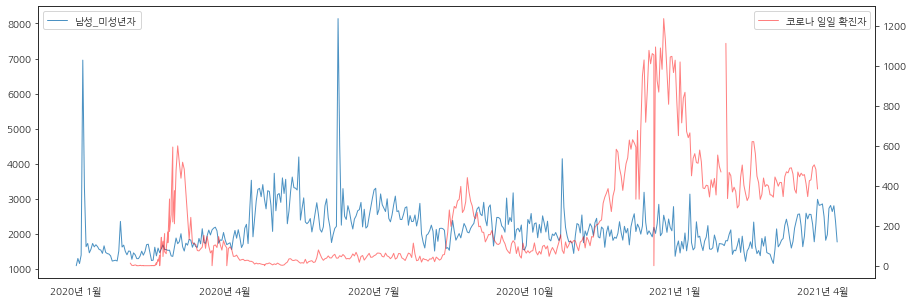

In [33]:
nut_graph(["남성_미성년자"])

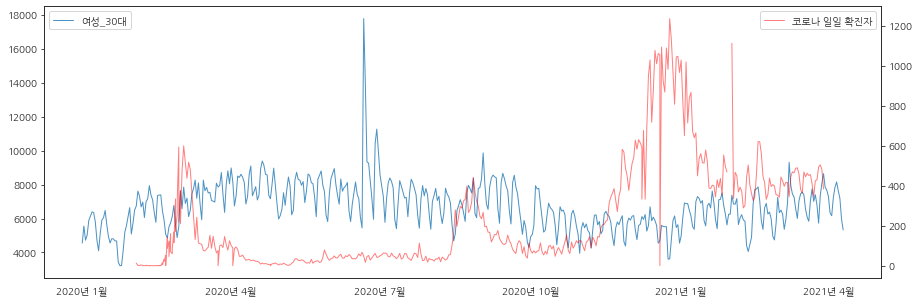

In [34]:
diet_graph(["여성_30대"])

#### 4. 검색량 기준 인기 카테고리  연도별로 보기 
- 연도별 영양제 검색량 순위(1위~5위)
- 연도별 다이어트식품 검색량 순위(1위~5위)

In [35]:
#### 추가처리 - 연도 및 연도+월 컬럼 추가 

In [36]:
nut_total.insert(0, "year", nut_total["date"].apply(lambda x : x[0:4]))

In [37]:
nut_total.insert(1, "yyyymm", nut_total["date"].apply(lambda x : x[0:7]))

In [38]:
food_total.insert(0, "year", food_total["date"].apply(lambda x : x[0:4]))

In [39]:
food_total.insert(1, "yyyymm", food_total["date"].apply(lambda x : x[0:7]))

In [40]:
#영양제 랭킹 데이터프레임 만들기
nut_rank = pd.DataFrame()
nut_rank["rank"] = [1, 2, 3, 4, 5]

#연도별로 묶은 후 반복문으로 1~5위 뽑아서 데이터프레임에 붙이기 
dummy = nut_total.groupby(["year", "cate_5"]).sum()
dummy.insert(0, "sum", dummy.sum(axis=1))
dummy = dummy.reset_index()
year_list = ["2018", "2019", "2020", "2021"]

for i, year in enumerate(year_list): 
    data = dummy[dummy["year"] == year].sort_values(by="sum", ascending=False)
    nut_rank[year] = list(data[:5]["cate_5"])

In [41]:
#다이어트식품 랭킹 데이터프레임 만들기
diet_rank = pd.DataFrame()
diet_rank["rank"] = [1, 2, 3, 4, 5]

#연도별로 묶은 후 반복문으로 1~5위 뽑아서 데이터프레임에 붙이기 
dummy = food_total.groupby(["year", "cate_5"]).sum()
dummy.insert(0, "sum", dummy.sum(axis=1))
dummy = dummy.reset_index()
year_list = ["2018", "2019", "2020", "2021"]

for i, year in enumerate(year_list): 
    data = dummy[dummy["year"] == year].sort_values(by="sum", ascending=False)
    diet_rank[year] = list(data[:5]["cate_5"])

In [42]:
nut_rank

,rank,2018,2019,2020,2021
0,1,프로바이오틱스,프로바이오틱스,프로바이오틱스,건강분말
1,2,밀크씨슬,크릴오일,건강분말,프로바이오틱스
2,3,비타민D,프리바이오틱스,밀크씨슬,밀크씨슬
3,4,폴리코사놀,건강분말,타트체리,비타민D
4,5,프리바이오틱스,밀크씨슬,비타민D,타트체리


In [43]:
diet_rank

,rank,2018,2019,2020,2021
0,1,레몬밤,헬스보충제,헬스보충제,콜라겐
1,2,곤약젤리,레몬밤,콜라겐,헬스보충제
2,3,헬스보충제,콜라겐,곤약젤리,곤약쌀
3,4,가르시니아,곤약젤리,기타곤약가공품,곤약젤리
4,5,와일드망고,와일드망고,곤약쌀,기타곤약가공품


#### 5. 연도별 검색량 변화 추이(2018, 2019, 2020) 
- 영양제 연도별 검색량
- 다이어트식품 연도별 검색량 추이

In [44]:
#영양제 
dummy_nut = nut_total.groupby(["year"]).sum()
dummy_nut = dummy_nut.iloc[:3,:] #2021년 제외
dummy_nut

,남성_미성년자,남성_20대,남성_30대,남성_40대,남성_50대이상,여성_미성년자,여성_20대,여성_30대,여성_40대,여성_50대이상
year,,,,,,,,,,
2018,782602.170936,4.692503e+06,4.626591e+06,2.565151e+06,1.153806e+06,1.153213e+06,6.256407e+06,7.564168e+06,4.270644e+06,2.089153e+06
2019,983193.636707,8.094504e+06,8.292451e+06,4.630954e+06,2.134292e+06,1.140311e+06,9.816020e+06,1.259100e+07,8.086554e+06,4.361665e+06
2020,806348.854705,5.964096e+06,6.651289e+06,4.857296e+06,2.749468e+06,1.257960e+06,8.928075e+06,1.253079e+07,9.861022e+06,6.192870e+06


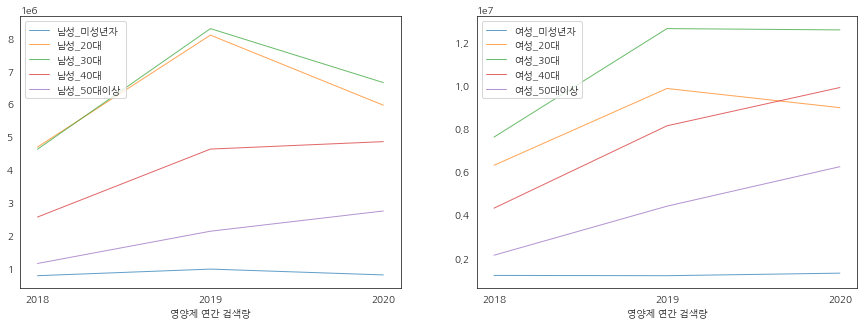

In [45]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.plot(dummy_nut.index, dummy_nut.iloc[:,:5], lw=1, alpha=0.7)
ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
plt.xlabel("영양제 연간 검색량")

ax2 = plt.subplot(122)
ax2.plot(dummy_nut.index, dummy_nut.iloc[:,5:], lw=1, alpha=0.7)
ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
plt.xlabel("영양제 연간 검색량")

plt.show()

In [46]:
#다이어트식품
dummy_food = food_total.groupby(["year"]).sum()
dummy_food = dummy_nut.iloc[:3,:] #2021년 제외
dummy_food

,남성_미성년자,남성_20대,남성_30대,남성_40대,남성_50대이상,여성_미성년자,여성_20대,여성_30대,여성_40대,여성_50대이상
year,,,,,,,,,,
2018,782602.170936,4.692503e+06,4.626591e+06,2.565151e+06,1.153806e+06,1.153213e+06,6.256407e+06,7.564168e+06,4.270644e+06,2.089153e+06
2019,983193.636707,8.094504e+06,8.292451e+06,4.630954e+06,2.134292e+06,1.140311e+06,9.816020e+06,1.259100e+07,8.086554e+06,4.361665e+06
2020,806348.854705,5.964096e+06,6.651289e+06,4.857296e+06,2.749468e+06,1.257960e+06,8.928075e+06,1.253079e+07,9.861022e+06,6.192870e+06


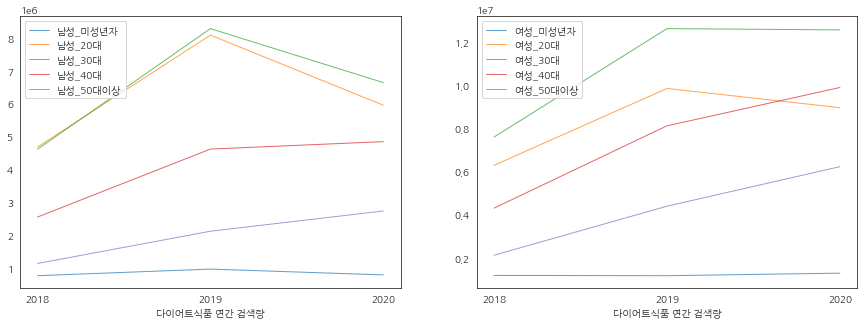

In [47]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.plot(dummy_food.index, dummy_food.iloc[:,:5], lw=1, alpha=0.7)
ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
plt.xlabel("다이어트식품 연간 검색량")

ax2 = plt.subplot(122)
ax2.plot(dummy_food.index, dummy_food.iloc[:,5:], lw=1, alpha=0.7)
ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
plt.xlabel("다이어트식품 연간 검색량")

plt.show()

#### 6. 전체 검색량 변화 추이 
- 영양제 월별 검색량
- 다이어트식품 월별 검색량 추이

In [48]:
#영양제 
dummy_nut = nut_total.groupby(["yyyymm"]).sum()
dummy_nut = dummy_nut[:-1] #2021년 4월 데이터 제외(4월 10일까지만 있기 때문)
dummy_nut["sum"] = dummy_nut.sum(axis=1)

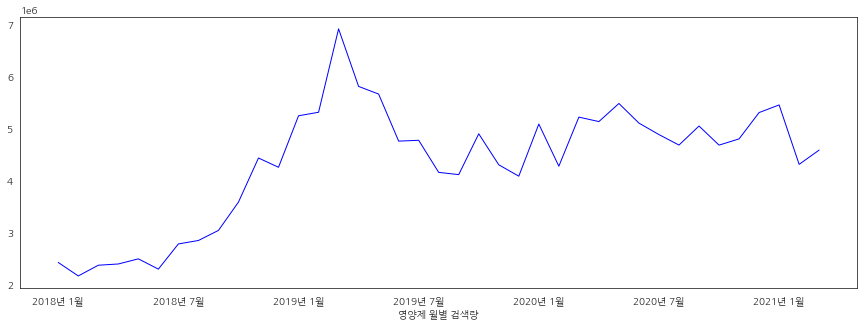

In [81]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

plt.plot(dummy_nut.index, dummy_nut["sum"], lw=1, color="blue", alpha=1)
plt.xlabel("영양제 월별 검색량")
plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

plt.show()

In [50]:
#다이어트식품
dummy_food = food_total.groupby(["yyyymm"]).sum()
dummy_food = dummy_food[:-1] #2021년 4월 데이터 제외(4월 10일까지만 있기 때문)
dummy_food["sum"] = dummy_food.sum(axis=1)

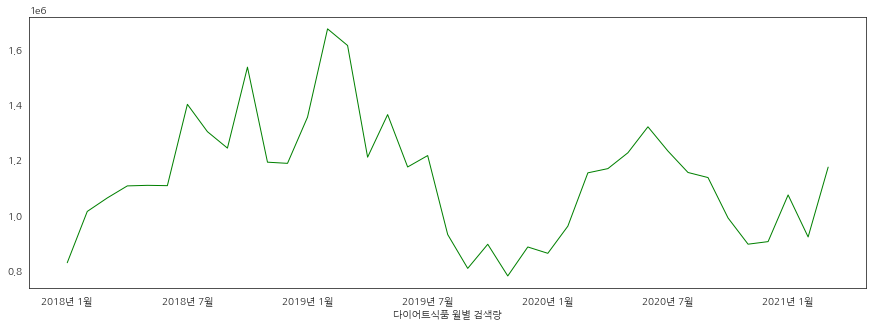

In [80]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

plt.plot(dummy_food.index, dummy_food["sum"], color="green", lw=1, alpha=1)
plt.xlabel("다이어트식품 월별 검색량")
plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

plt.show()

In [ ]:
def drawgraph(*args) : 
    plt.figure(figsize = (10,7))
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'NanumGothic'
    name_list = []
    for i in args : 
        sns.lineplot(x= "date", y = i, alpha = 0.7, data=group_total.iloc[:-1])
        name_list.append(i)
    plt.xticks(["1801", "1807","1901", "1907","2001","2007", "2101"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])
    plt.ylabel("월간 검색량")
    plt.legend(group_total[name_list].iloc[:-1])
    plt.show()

In [82]:
total_trend.head()

,date,수면보조제,아르기닌(아미노산),효소,은행추출물,초록입홍합,헤모힘,타트체리,매스틱,구연산,...,기타곤약가공품,다이어트바,잔티젠,레몬밤,CLA,카테킨,히알루론산,와일드망고,food_sum,daycnt
0,2020-01-01,353.6,2218.8,1051.4,211.0,333.7,500.0,41.8,650.9,159.9,...,703.4,442.4,741.2,854.6,424.2,229.3,1034.4,88.9,18258.8,0.0
1,2020-01-02,683.5,4471.8,1406.0,277.6,402.1,577.0,65.6,1456.5,192.0,...,985.8,527.6,1018.8,1046.9,509.0,278.5,1231.6,108.2,23889.2,NaN
2,2020-01-03,550.4,4253.2,1703.5,262.4,376.4,558.0,68.4,653.9,171.1,...,904.7,548.2,849.8,938.4,512.0,228.8,1204.7,100.6,20579.2,NaN
3,2020-01-04,403.1,4477.5,1416.4,238.6,281.4,567.5,45.6,535.1,185.3,...,840.8,410.8,849.8,1018.8,478.6,241.6,1207.6,90.1,22239.0,NaN
4,2020-01-05,445.8,5089.7,1493.4,249.1,2800.6,480.1,45.6,567.2,174.1,...,986.5,546.1,909.5,1007.8,488.0,221.8,1164.3,98.9,24209.4,NaN


#### 7. 개별 제품의 검색량 변화 추이 

In [123]:
#영양제 검색량 - 남녀 나눠그리기(남녀 검색량 자체가 차이나기 때문에 따로 그림)
#catename에 개별 제품을 넣으면 되는 함수 

def nut_trend(catename) : 

    dummy = nut_total[nut_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))

    ax1 = plt.subplot(121)
    ax1.plot(dummy.index, dummy.iloc[:,:5], lw=1, alpha=0.85)
    ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    ax2 = plt.subplot(122)
    ax2.plot(dummy.index, dummy.iloc[:,5:], lw=1, alpha=0.85)
    ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    plt.show()

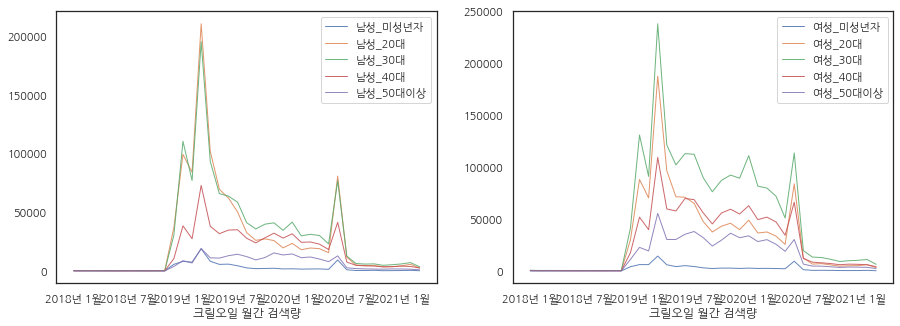

In [352]:
nut_trend("크릴오일")

In [124]:
#영양제 검색량
#catename에 개별 제품을 넣고, grouplist에 비교하고자 하는 그룹을 리스트 형태로 넣으면 되는 함수 


def nut_trend_v2(catename, grouplist) : 

    dummy = nut_total[nut_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))


    ax1 = plt.subplot(111)
    
    for i, value in enumerate(grouplist) : 
        ax1.plot(dummy.index, dummy[value], "-", lw=1, label = f"{value}")
        ax1.legend(loc = "upper left")  

    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])
    plt.show()

ConversionError: Failed to convert value(s) to axis units: ['2018-01', '2018-07', '2019-01', '2019-07', '2020-01', '2020-07', '2021-01']

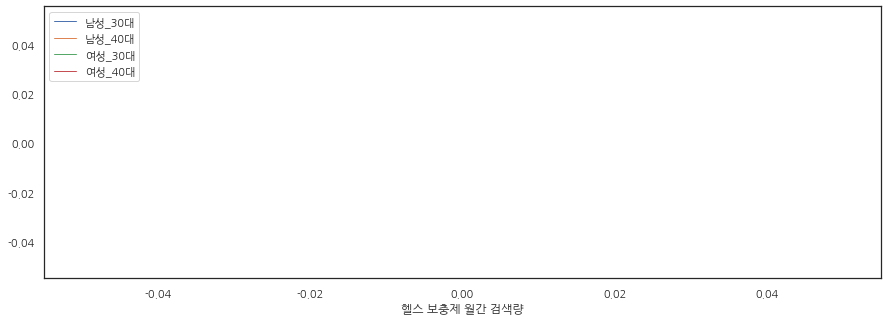

In [360]:
nut_trend_v2("헬스 보충제", ["남성_30대", "남성_40대", "여성_30대", "여성_40대"])

In [125]:
#다이어트식품 검색량 - 남녀 나눠그리기(남녀 검색량 자체가 차이나기 때문에 따로 그림)
#catename에 개별 제품을 넣으면 되는 함수 

def food_trend(catename) : 

    dummy = food_total[food_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))

    ax1 = plt.subplot(121)
    ax1.plot(dummy.index, dummy.iloc[:,:5], lw=1, alpha=0.85)
    ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    ax2 = plt.subplot(122)
    ax2.plot(dummy.index, dummy.iloc[:,5:], lw=1, alpha=0.85)
    ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    plt.show()

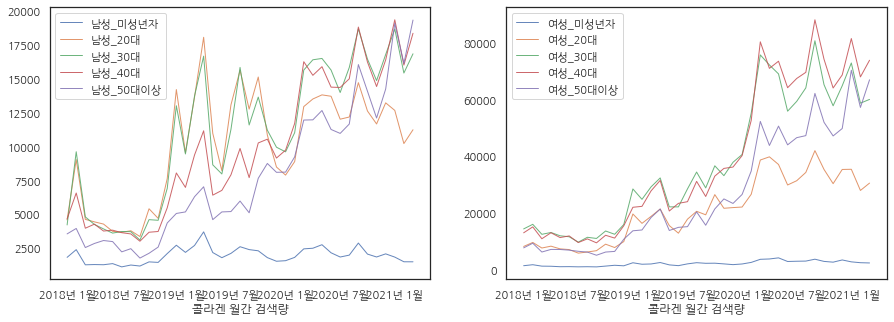

In [191]:
food_trend("콜라겐")

In [127]:
#다이어트식품 검색량
#catename에 개별 제품을 넣고, grouplist에 비교하고자 하는 그룹을 리스트 형태로 넣으면 되는 함수 


def food_trend_v2(catename, grouplist) : 

    dummy = food_total[food_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))


    ax1 = plt.subplot(111)
    
    for i, value in enumerate(grouplist) : 
        ax1.plot(dummy.index, dummy[value], "-", lw=1, label = f"{value}")
        ax1.legend(loc = "upper left")  

    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])
    plt.show()

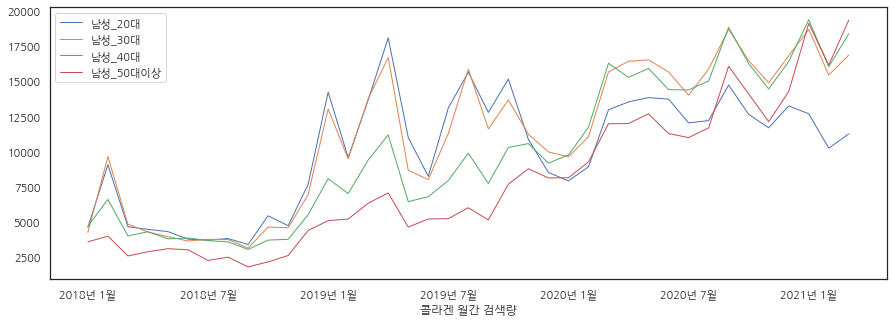

In [195]:
food_trend_v2("콜라겐", ["남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])

#### 8. 일자별 영양제 1등 뽑기 (참고용으로 제작) 

In [206]:
nut_best = nut_total.copy()
nut_best["sum"] = nut_best[4:].sum(axis=1)

In [208]:
nut_best = nut_best.pivot(index="date", columns="cate_5", values="sum")
nut_best = nut_best.reset_index()

In [334]:
nut_best_2020 = nut_best[nut_best["date"] >= "2020-01-01"]
nut_best_2020 = nut_best_2020[nut_best_2020["date"] <= "2020-07-31"]

In [335]:
nut_best_2020 = nut_best_2020.set_index("date").T


date,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31
cate_5,,,,,,,,,,,,,,,,,,,,,
MSM,2218.848047,2365.279609,2284.758936,2115.460280,2400.994790,2430.333220,2497.732797,2408.525349,2337.299906,2372.151803,...,2351.684086,2358.929426,2047.683924,2013.183860,2174.984928,2561.149452,2475.077623,2417.282848,2293.224902,2312.689128
SAMe,339.249775,399.342525,330.018844,277.014669,320.157630,441.076326,451.415818,488.794988,452.493145,387.970214,...,475.160895,445.063410,413.936246,299.782874,332.906891,495.977769,465.156656,401.847496,458.416000,373.437124
감마리놀렌산,1637.206101,2226.597252,2009.891355,1908.188423,2048.522793,2241.538205,2400.035710,2145.558655,4113.966275,4329.217238,...,2151.632935,2020.795414,1962.839350,1697.977233,1724.885352,2229.613375,2433.524447,2421.738584,2197.735123,1999.814260
건강분말,2452.847465,3579.766357,3143.619782,2519.374437,4289.149283,4542.170519,3920.894439,3930.707210,3470.683626,2358.537524,...,19140.502402,15384.539885,19326.108715,13884.140546,14718.071765,14471.924149,15302.402910,12482.532207,14072.857071,11620.823862
건강음료,2621.156691,2479.546399,2106.939310,2161.422746,2612.118199,2697.088276,2449.184634,2425.401780,2736.186135,2652.774366,...,2808.968081,2503.267559,2219.943332,2370.843645,2591.071693,2721.415133,2624.256172,2436.806243,2414.397599,1883.267626
건강환/정,970.807331,1370.042541,1226.953864,1311.590303,1243.251326,1519.705801,1469.628051,1384.280798,1254.459868,984.710700,...,1091.461490,1243.539623,983.279615,953.855196,1122.364017,1260.100377,1287.764215,1184.285676,1173.505907,1053.730629
구연산,210.510970,247.611055,206.715410,216.401202,234.711515,267.135958,270.263502,280.239312,250.173567,246.820006,...,212.094154,213.137397,209.480785,192.384082,164.516471,226.097479,213.638037,313.213085,261.184194,219.639369
글루코사민,773.971440,772.225994,843.905808,794.918395,1002.618974,1025.974720,958.916962,1080.991343,1054.834941,802.046698,...,982.063723,943.284089,872.311851,808.775700,783.434807,972.218645,945.180171,936.091322,806.884554,752.962189
기타건강보조식품,2524.668101,3171.295503,3132.970850,5837.409501,5703.554910,3985.133788,5001.106155,3960.777037,3691.122447,3554.596986,...,4088.781561,3411.156630,3165.630853,2918.787992,3022.074429,3655.470390,3457.516665,3478.291312,3238.335330,2925.134155


In [336]:
datelist = list(nut_best_2020.columns)
search_list = []
index_list = []

for date in datelist: 
    max_search = nut_best_2020[date].max()
    max_index = nut_best_2020.index[nut_best_2020[date] == max_search].tolist()
    search_list.append(max_search)
    index_list.append(max_index[0])
    

In [337]:
max_df = pd.DataFrame({"date":datelist, 
                      "max_index":index_list, 
                      "max_search":search_list})

In [343]:
max_df.sort_values(by="max_search", ascending=False)

,date,max_index,max_search
160,2020-06-09,크릴오일,266388.595626
4,2020-01-05,타우린,261727.851920
5,2020-01-06,타우린,203926.776998
161,2020-06-10,크릴오일,127152.333835
135,2020-05-15,건강분말,70983.987124
...,...,...,...
212,2020-07-31,프로바이오틱스,12451.144088
23,2020-01-24,프로바이오틱스,11574.911279
156,2020-06-05,프로바이오틱스,11517.077479
22,2020-01-23,프로바이오틱스,10718.836680


#### 9. 면역력 관련 키워드 검색량과 확진자 수 비교 (참고자료)

In [308]:
search_immune = pd.read_excel("data/search_immune.xlsx")

In [310]:
search_immune = search_immune[search_immune["날짜"] <= "2021-03-29"]

In [311]:
search_immune["covid"] = covid["daycnt"]

<ipython-input-311-b554b16cf355>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_immune["covid"] = covid["daycnt"]


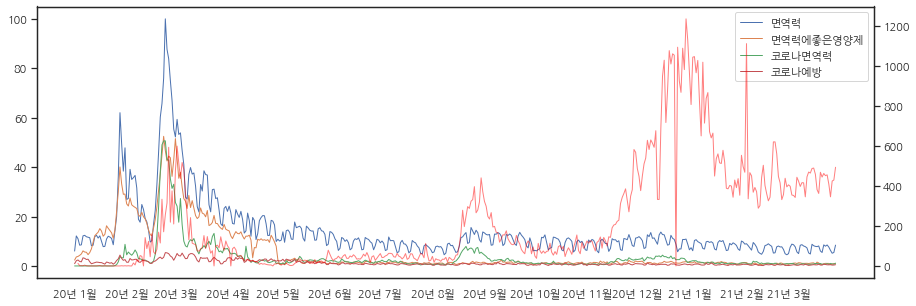

In [333]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(111)
ax2 = ax1.twinx()
plot1 = ax1.plot(search_immune["날짜"], search_immune["면역력"], "-", lw=1, alpha=1, 
                 label = "면역력")
plot1 = ax1.plot(search_immune["날짜"], search_immune["면역력에좋은영양제"], "-", lw=1, alpha=1, 
                 label = "면역력에좋은영양제")
plot1 = ax1.plot(search_immune["날짜"], search_immune["코로나면역력"], "-", lw=1, alpha=1, 
                 label = "코로나면역력")
plot1 = ax1.plot(search_immune["날짜"], search_immune["코로나예방"], "-", lw=1, alpha=1, 
                 label = "코로나예방")

plot2 = ax2.plot(search_immune["날짜"], search_immune["covid"], "-", lw=1, color="red", alpha=0.5, label= "코로나 일일 확진자")

plt.xticks(rotation=45, ticks=["2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", 
            "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01", "2021-03-01"], 
          labels = ["20년 1월", "20년 2월", "20년 3월", "20년 4월", "20년 5월", "20년 6월", "20년 7월", "20년 8월"
                  , "20년 9월", "20년 10월", "20년 11월", "20년 12월", "21년 1월", "21년 2월", "21년 3월"])


ax1.legend(loc = "best")
